In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.set_random_seed(10)
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'font.size': 16, # was 10
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
plt.rcParams.update(params)

In [3]:
# Generating training data that goes from initial condition location to PCA coefficient trajectory
num_modes=40
locs = np.load('../../SWE_Data/Data/Locations.npy')
pca_coeffs = np.load('../../SWE_Data/PCA_Coefficients_q1.npy')[0:num_modes,:]
coeff_scaler = MinMaxScaler()
pca_coeffs_scaled = coeff_scaler.fit_transform(np.transpose(pca_coeffs))

In [4]:
# The total shape is large due to multiple simulations
num_samples_total = np.shape(pca_coeffs_scaled)[0]
num_sims = int(num_samples_total/500)
pca_coeffs_scaled = np.reshape(pca_coeffs_scaled,newshape=(num_sims,500,40))

In [5]:
state_len = np.shape(pca_coeffs_scaled)[-1]
seq_num = 20

num_samples = 500-seq_num-1
input_data = np.zeros(shape=(num_sims*num_samples,seq_num,state_len+2))
output_data = np.zeros(shape=(num_sims*num_samples,state_len))

batch_num = 0
for simnum in range(num_sims):            
    sub_data = pca_coeffs_scaled[simnum,:,:]

    for t in range(np.shape(sub_data)[0]-seq_num-1):
        input_seq = sub_data[t:t+seq_num,:]
        output_seq = sub_data[t+seq_num,:]
        input_data[batch_num,:,:state_len] = input_seq[None,:,:state_len]
        input_data[batch_num,:,-2] = locs[simnum,0]
        input_data[batch_num,:,-1] = locs[simnum,1]

        output_data[batch_num,:] = output_seq[:]
        batch_num = batch_num + 1

In [6]:
from tensorflow.keras.layers import Input, Dense, Lambda, Add, LSTM, Dropout
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

In [7]:
weights_filepath = 'A_LSTM_T.h5'

def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [8]:
# Optimal hyperparameters from Deephyper (row 1 of result.csv file)
lstm_inputs = Input(shape=(seq_num,state_len+2),name='at_inputs')
h1 = LSTM(106,return_sequences=True)(lstm_inputs)
h2 = LSTM(106,return_sequences=False)(h1)
lstm_outputs = Dense(state_len,activation=None)(h2)

lstm_model = Model(inputs=lstm_inputs,outputs=lstm_outputs)

# design network
my_adam = optimizers.Adam(lr=0.00966539233826535, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint,EarlyStoppingByLossVal()]

# fit network
lstm_model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination])    
lstm_model.summary()

W0204 10:44:18.644837 140622300477248 deprecation.py:506] From /home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
at_inputs (InputLayer)       [(None, 20, 42)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 20, 106)           63176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 106)               90312     
_________________________________________________________________
dense (Dense)                (None, 40)                4280      
Total params: 157,768
Trainable params: 157,768
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 500
batch_size = 256
train_mode = False ### Careful

from time import time

if train_mode:
    start_time = time()
    train_history = lstm_model.fit(x=input_data, y=output_data, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list)
    end_time = time()
    np.save('AT_LSTM_T.npy',train_history.history['loss'])

In [10]:
import matplotlib.pyplot as plt
lstm_model.load_weights(weights_filepath)
# Testing
filename = '../../SWE_Data/Data/snapshot_matrix_pod_test.npy'
test_data = np.load(filename)[0:64*64,:]
pca_vectors = np.load('../../SWE_Data/PCA_Vectors_q1.npy')[:,:num_modes]

true_pca_evol = coeff_scaler.transform(np.matmul(np.transpose(test_data),pca_vectors))
test_data = np.zeros(shape=(500,num_modes+2))
test_data[:,:num_modes] = true_pca_evol[:,:]

test_data[:,-2] = -1.0/2.7
test_data[:,-1] = -1.0/4.0

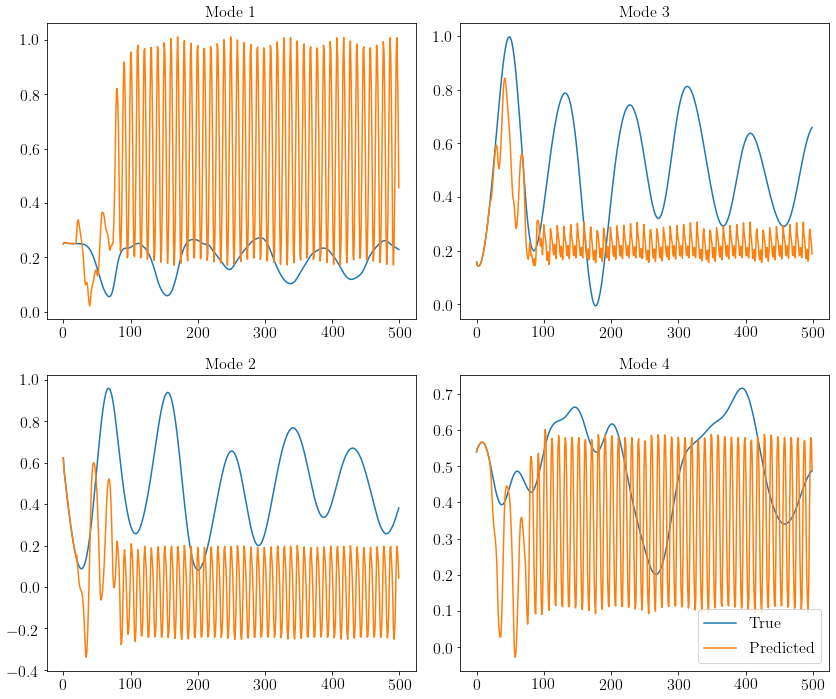

In [11]:
testing_inputs = np.copy(test_data)
num_preds = np.shape(testing_inputs)[0]

predictions = np.zeros_like(testing_inputs)
predictions[0:seq_num,:] = testing_inputs[0:seq_num,:]

for t in range(seq_num,num_preds):
    input_state = np.expand_dims(predictions[t-seq_num:t,:],0)
    output_state = lstm_model.predict(input_state)

    predictions[t,:state_len] = output_state[0,:]
    predictions[t,state_len:] = testing_inputs[t,state_len:]

fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,10))
ax[0,0].plot(testing_inputs[:,0],label='True')
ax[0,0].plot(predictions[:,0],label='Predicted')
ax[0,0].set_title('Mode 1')


ax[1,0].plot(testing_inputs[:,1],label='True')
ax[1,0].plot(predictions[:,1],label='Predicted')
ax[1,0].set_title('Mode 2')

ax[0,1].plot(testing_inputs[:,2],label='True')
ax[0,1].plot(predictions[:,2],label='Predicted')
ax[0,1].set_title('Mode 3')

ax[1,1].plot(testing_inputs[:,3],label='True')
ax[1,1].plot(predictions[:,3],label='Predicted')
ax[1,1].set_title('Mode 4')


plt.tight_layout()
plt.legend()
plt.show()


if train_mode:
    np.save('AT_LSTM_T_Preds.npy',predictions)

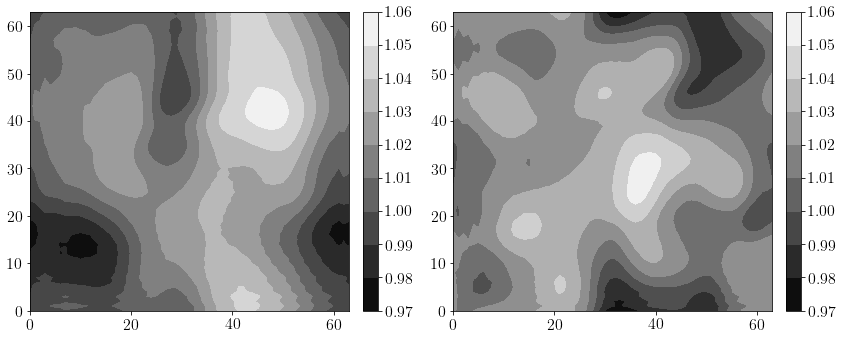

In [12]:
# Plotting some contours
# True field
true_rb = np.transpose(coeff_scaler.inverse_transform(true_pca_evol))
true_recon = np.matmul(pca_vectors,true_rb)[:,-1].reshape(64,64)

pred_rb = predictions[:,:-2]
pred_rb = np.transpose(coeff_scaler.inverse_transform(pred_rb))
pred_recon = np.matmul(pca_vectors,pred_rb)[:,-1].reshape(64,64)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
cx = ax[0].contourf(true_recon)
ax[1].contourf(pred_recon)

fig.colorbar(cx,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(cx,ax=ax[1],fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [13]:
if train_mode:
    np.save('Figures/A_LSTM_T_Preds.npy',predictions)
    np.save('Figures/A_LSTM_T_Fields.npy',pred_recon)